In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy             as np
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 300

from numpy.fft    import fft, ifft, fftfreq
from numpy.random import normal
from random       import choice
from math         import ceil

import sys
np.set_printoptions(threshold=sys.maxsize)

In [3]:
Fs = 22050
Ts = 1/Fs

A = 1
K = 15
W = 1470

BITS_PER_BYTE    = 8
NUMBERS_OF_BYTES = 10
NUMBER_OF_BITS   = NUMBERS_OF_BYTES * BITS_PER_BYTE
SIGNAL_LENGTH    = NUMBER_OF_BITS * K

t = np.linspace(0, Ts*NUMBER_OF_BITS, SIGNAL_LENGTH)
f = fftfreq(SIGNAL_LENGTH, Ts)
bits = [A if b else -A for b in [choice([True, False]) for _ in range(NUMBER_OF_BITS)]]

def passband_filter(frequencies, omega, width):
    filter = np.zeros(frequencies.size)
    for i in np.argwhere(abs(abs(frequencies)-omega) <= width/2):
        filter[i] = 1
    return filter

def decode(signal_input):
    signal_output = []
    
    for i in range(NUMBER_OF_BITS):
        acc = 0
        for j in range(K):
            acc += signal_input[i * K + j]
        signal_output.append(acc//K)
        
    return signal_output

def cos_modulation(frequency):
    return np.array([np.cos(2*np.pi*frequency*a*Ts) for a in range(SIGNAL_LENGTH)])

def modulation():
    return (cos_modulation(2000) + \
            cos_modulation(4000) + \
            cos_modulation(6000) + \
            cos_modulation(8000)) / 4

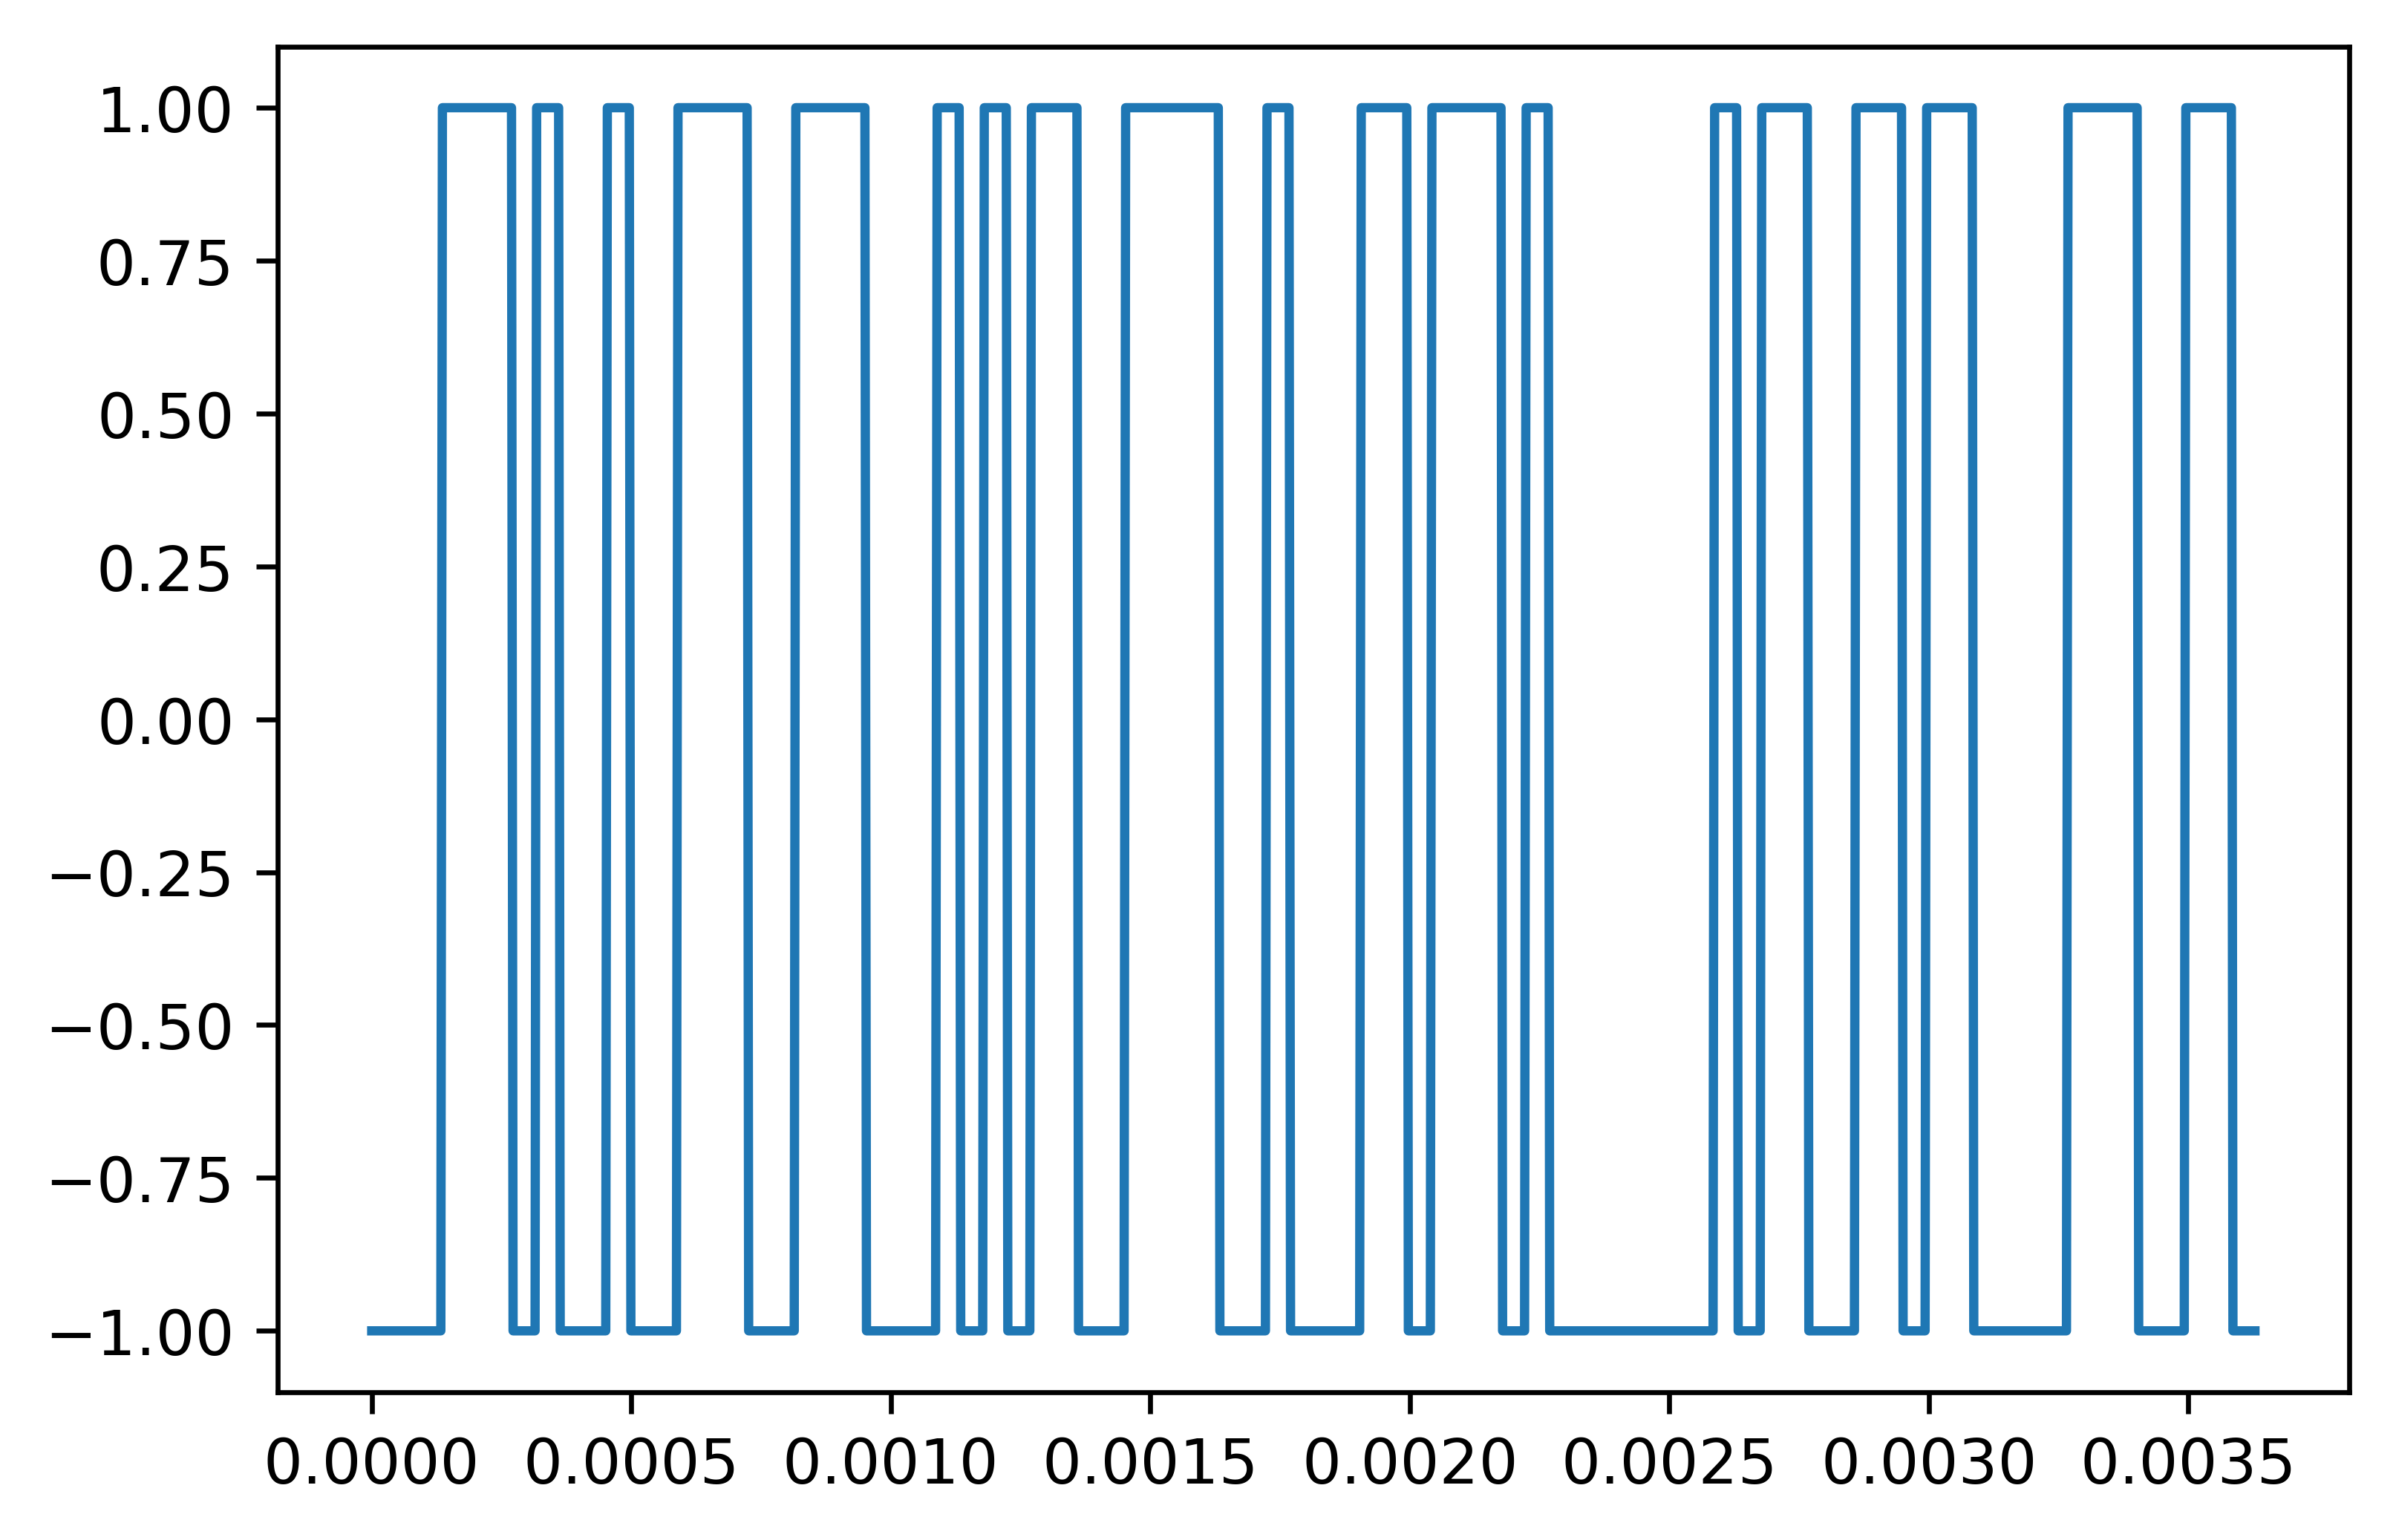

In [4]:
signal = np.repeat(bits, K)
plt.plot(t, signal)
plt.show()

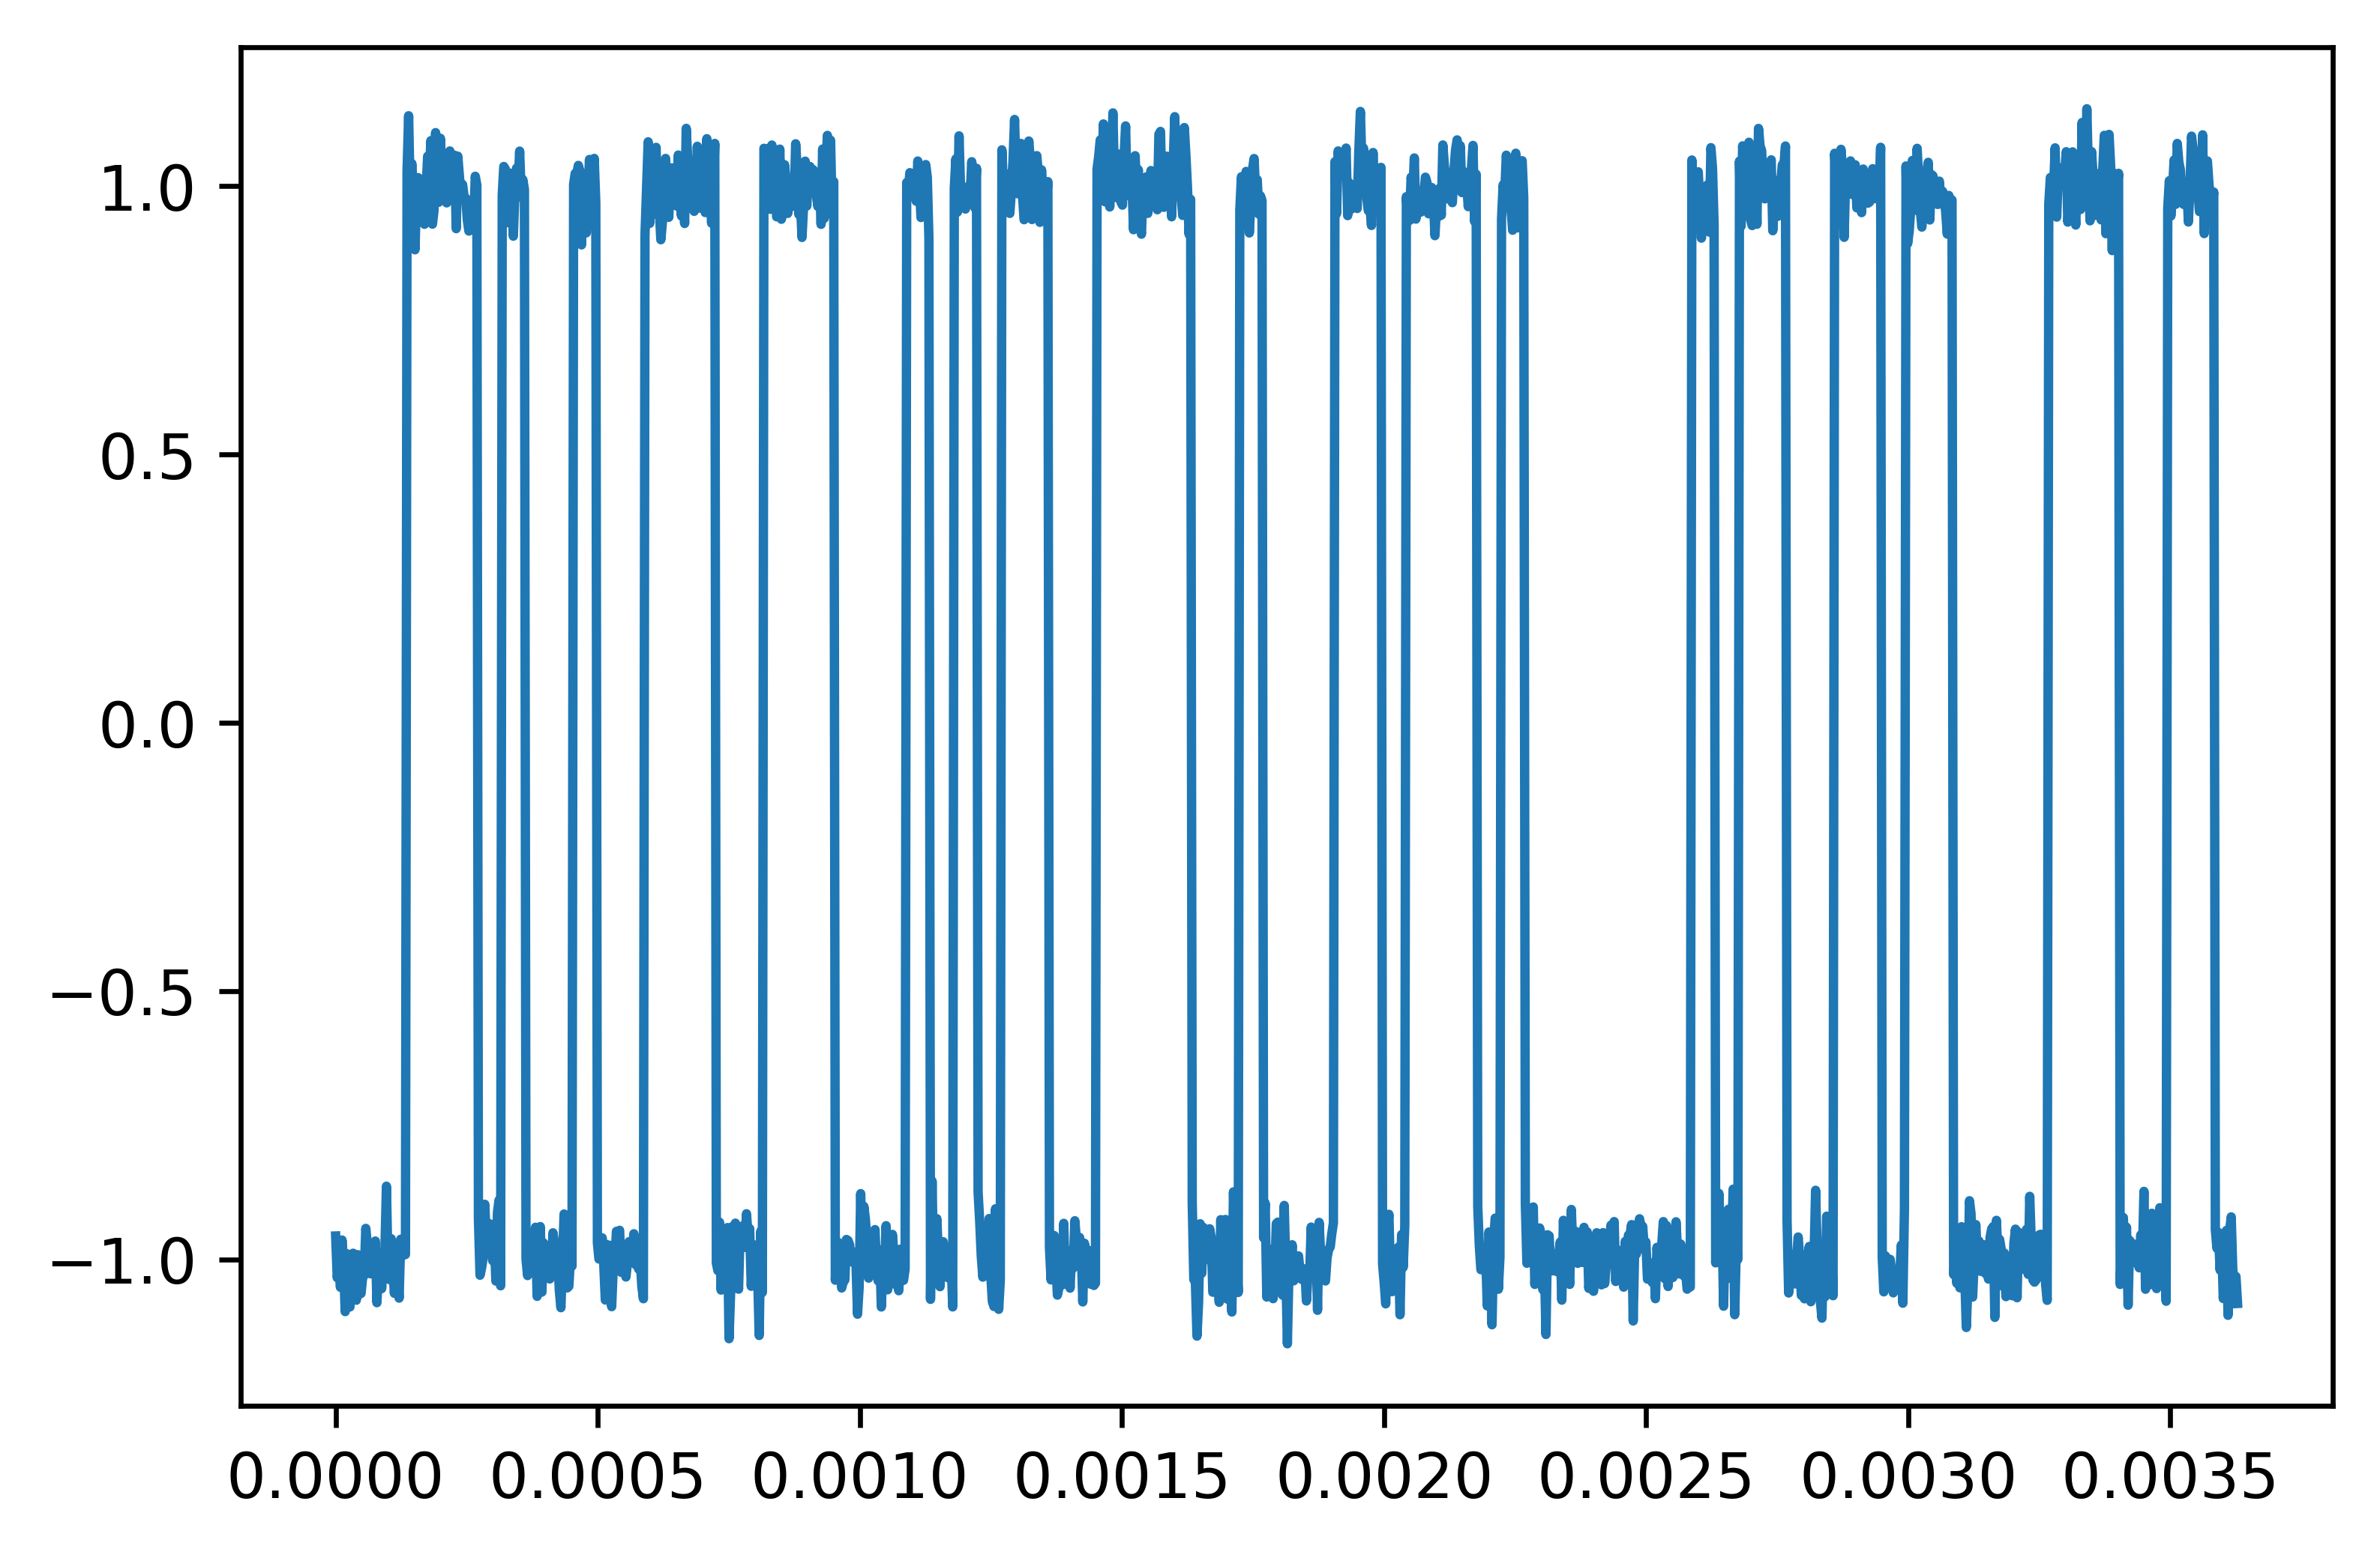

In [5]:
white_noise = normal(0, 0.05, SIGNAL_LENGTH)
noisy_signal = signal+white_noise
plt.plot(t, noisy_signal)
plt.show()

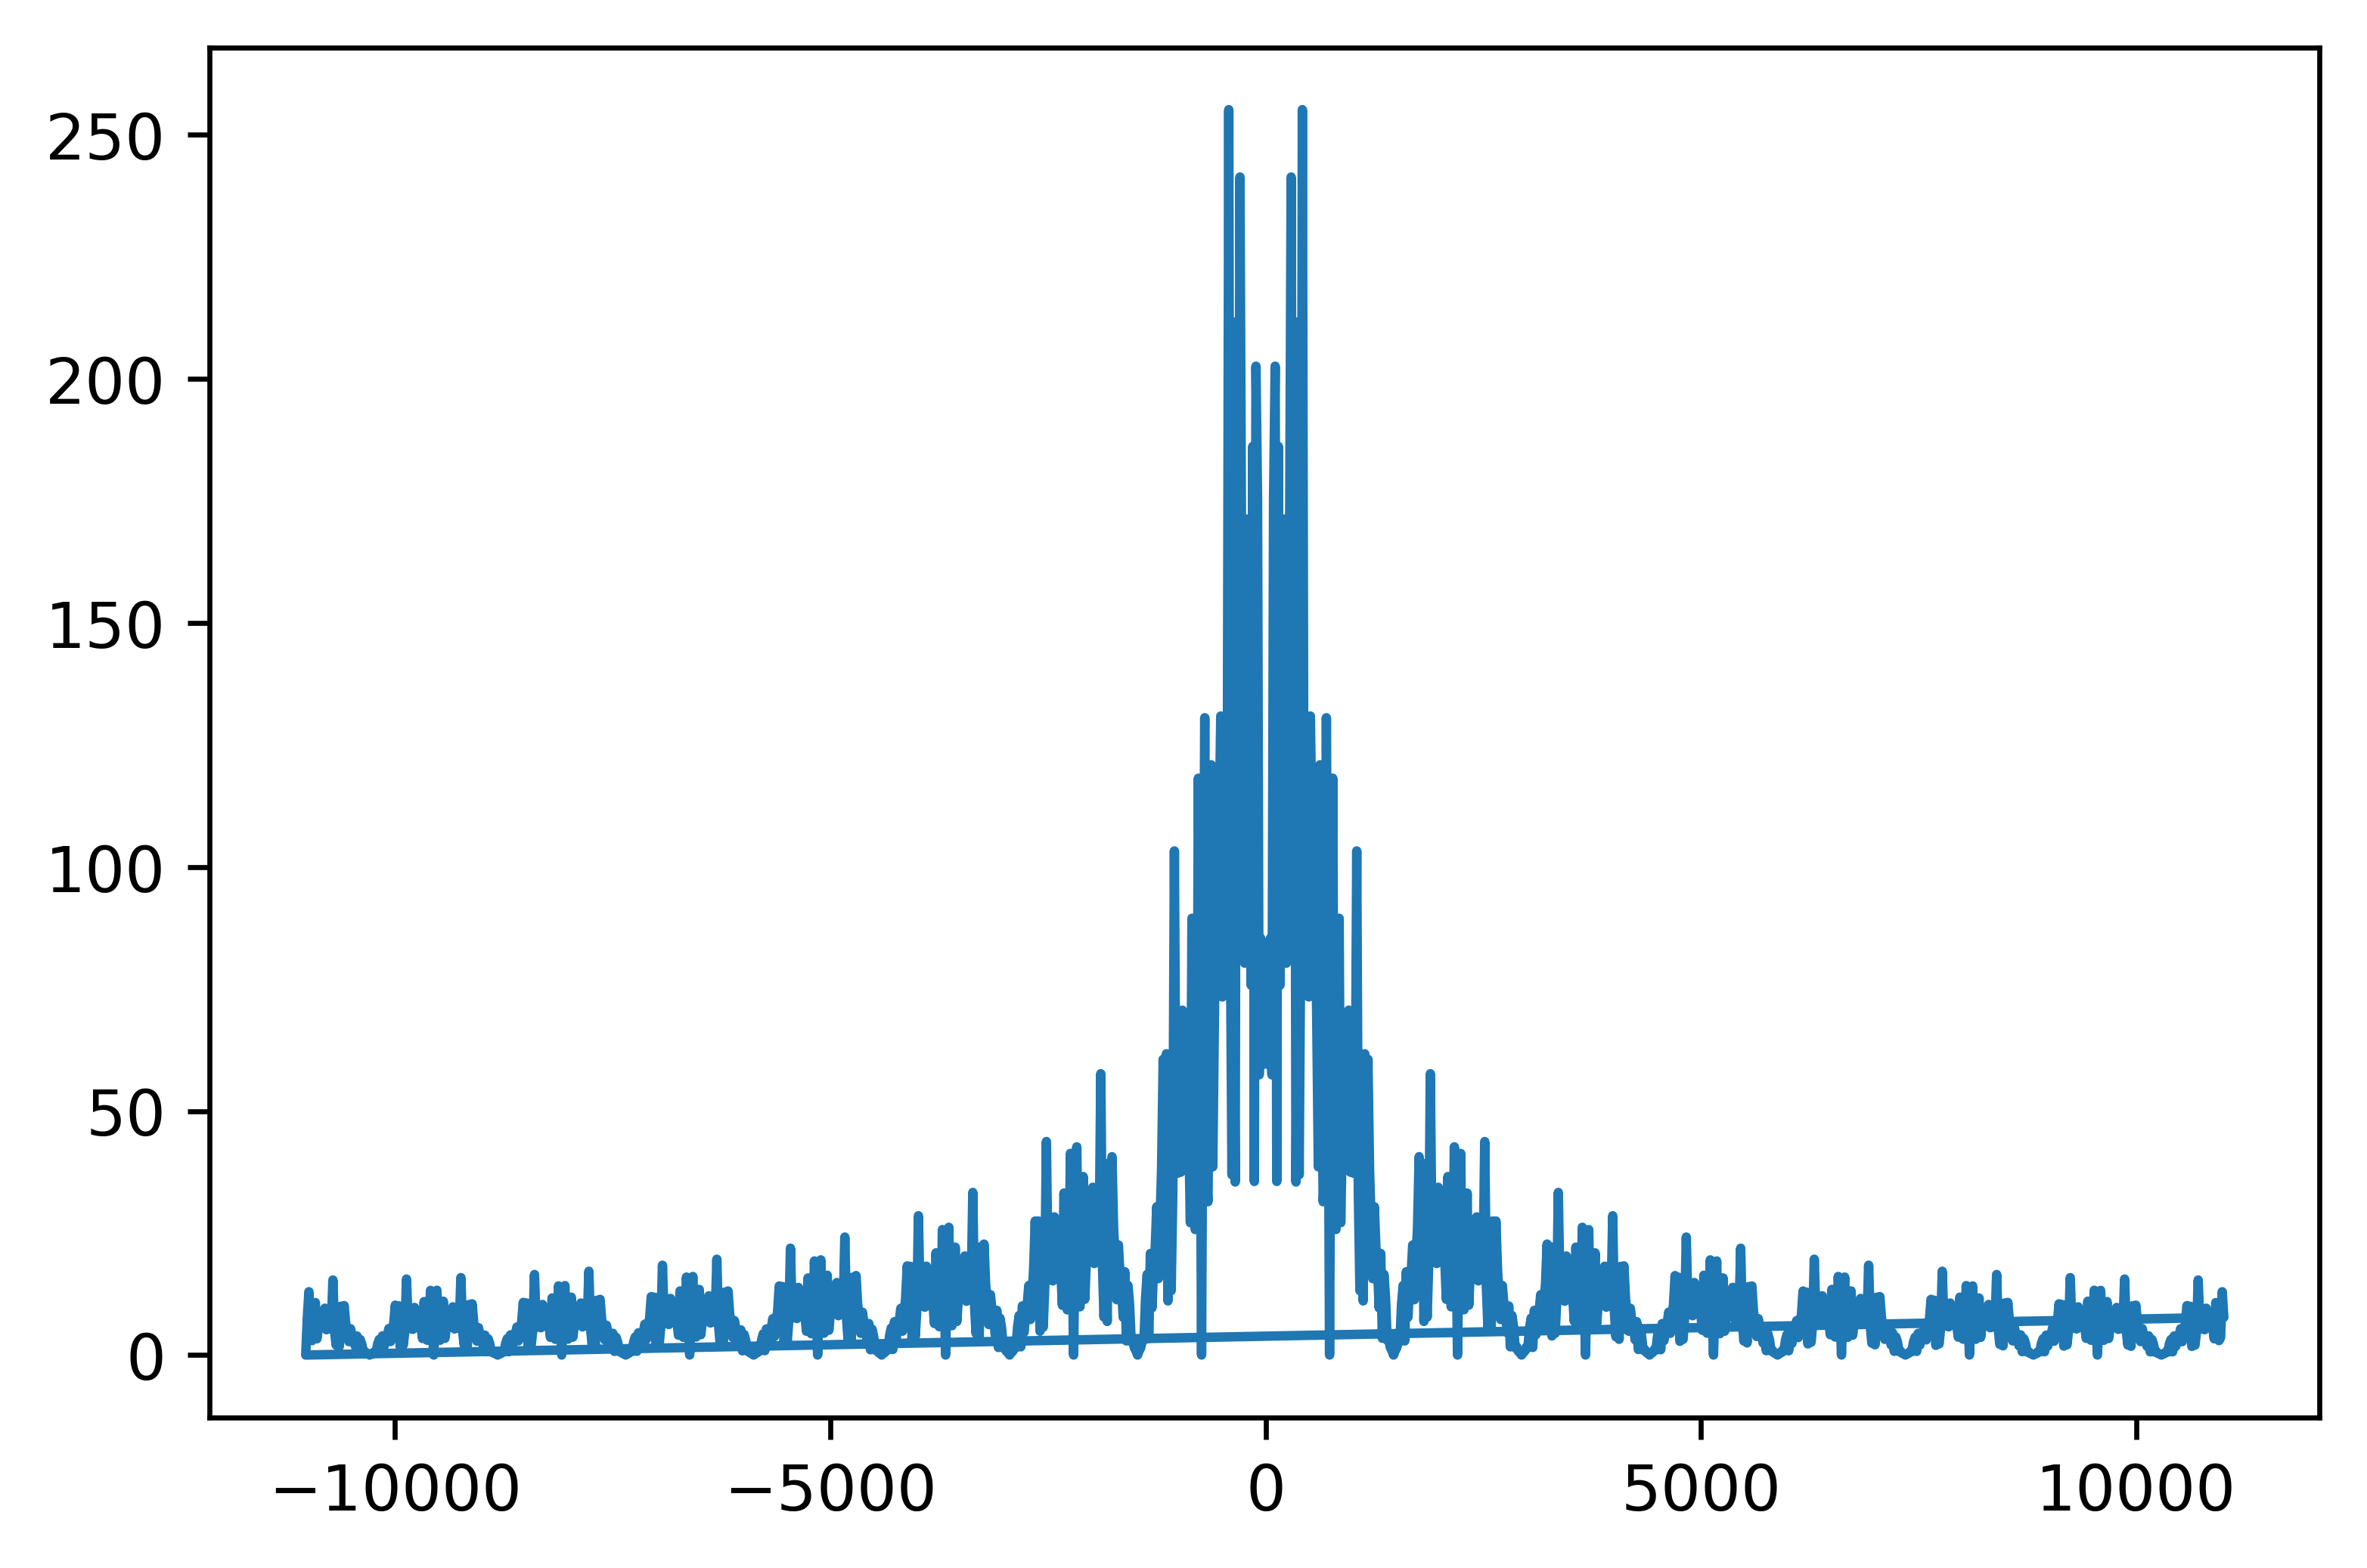

In [6]:
signal_frequencies = fft(signal)
plt.plot(f, abs(signal_frequencies))
plt.show()

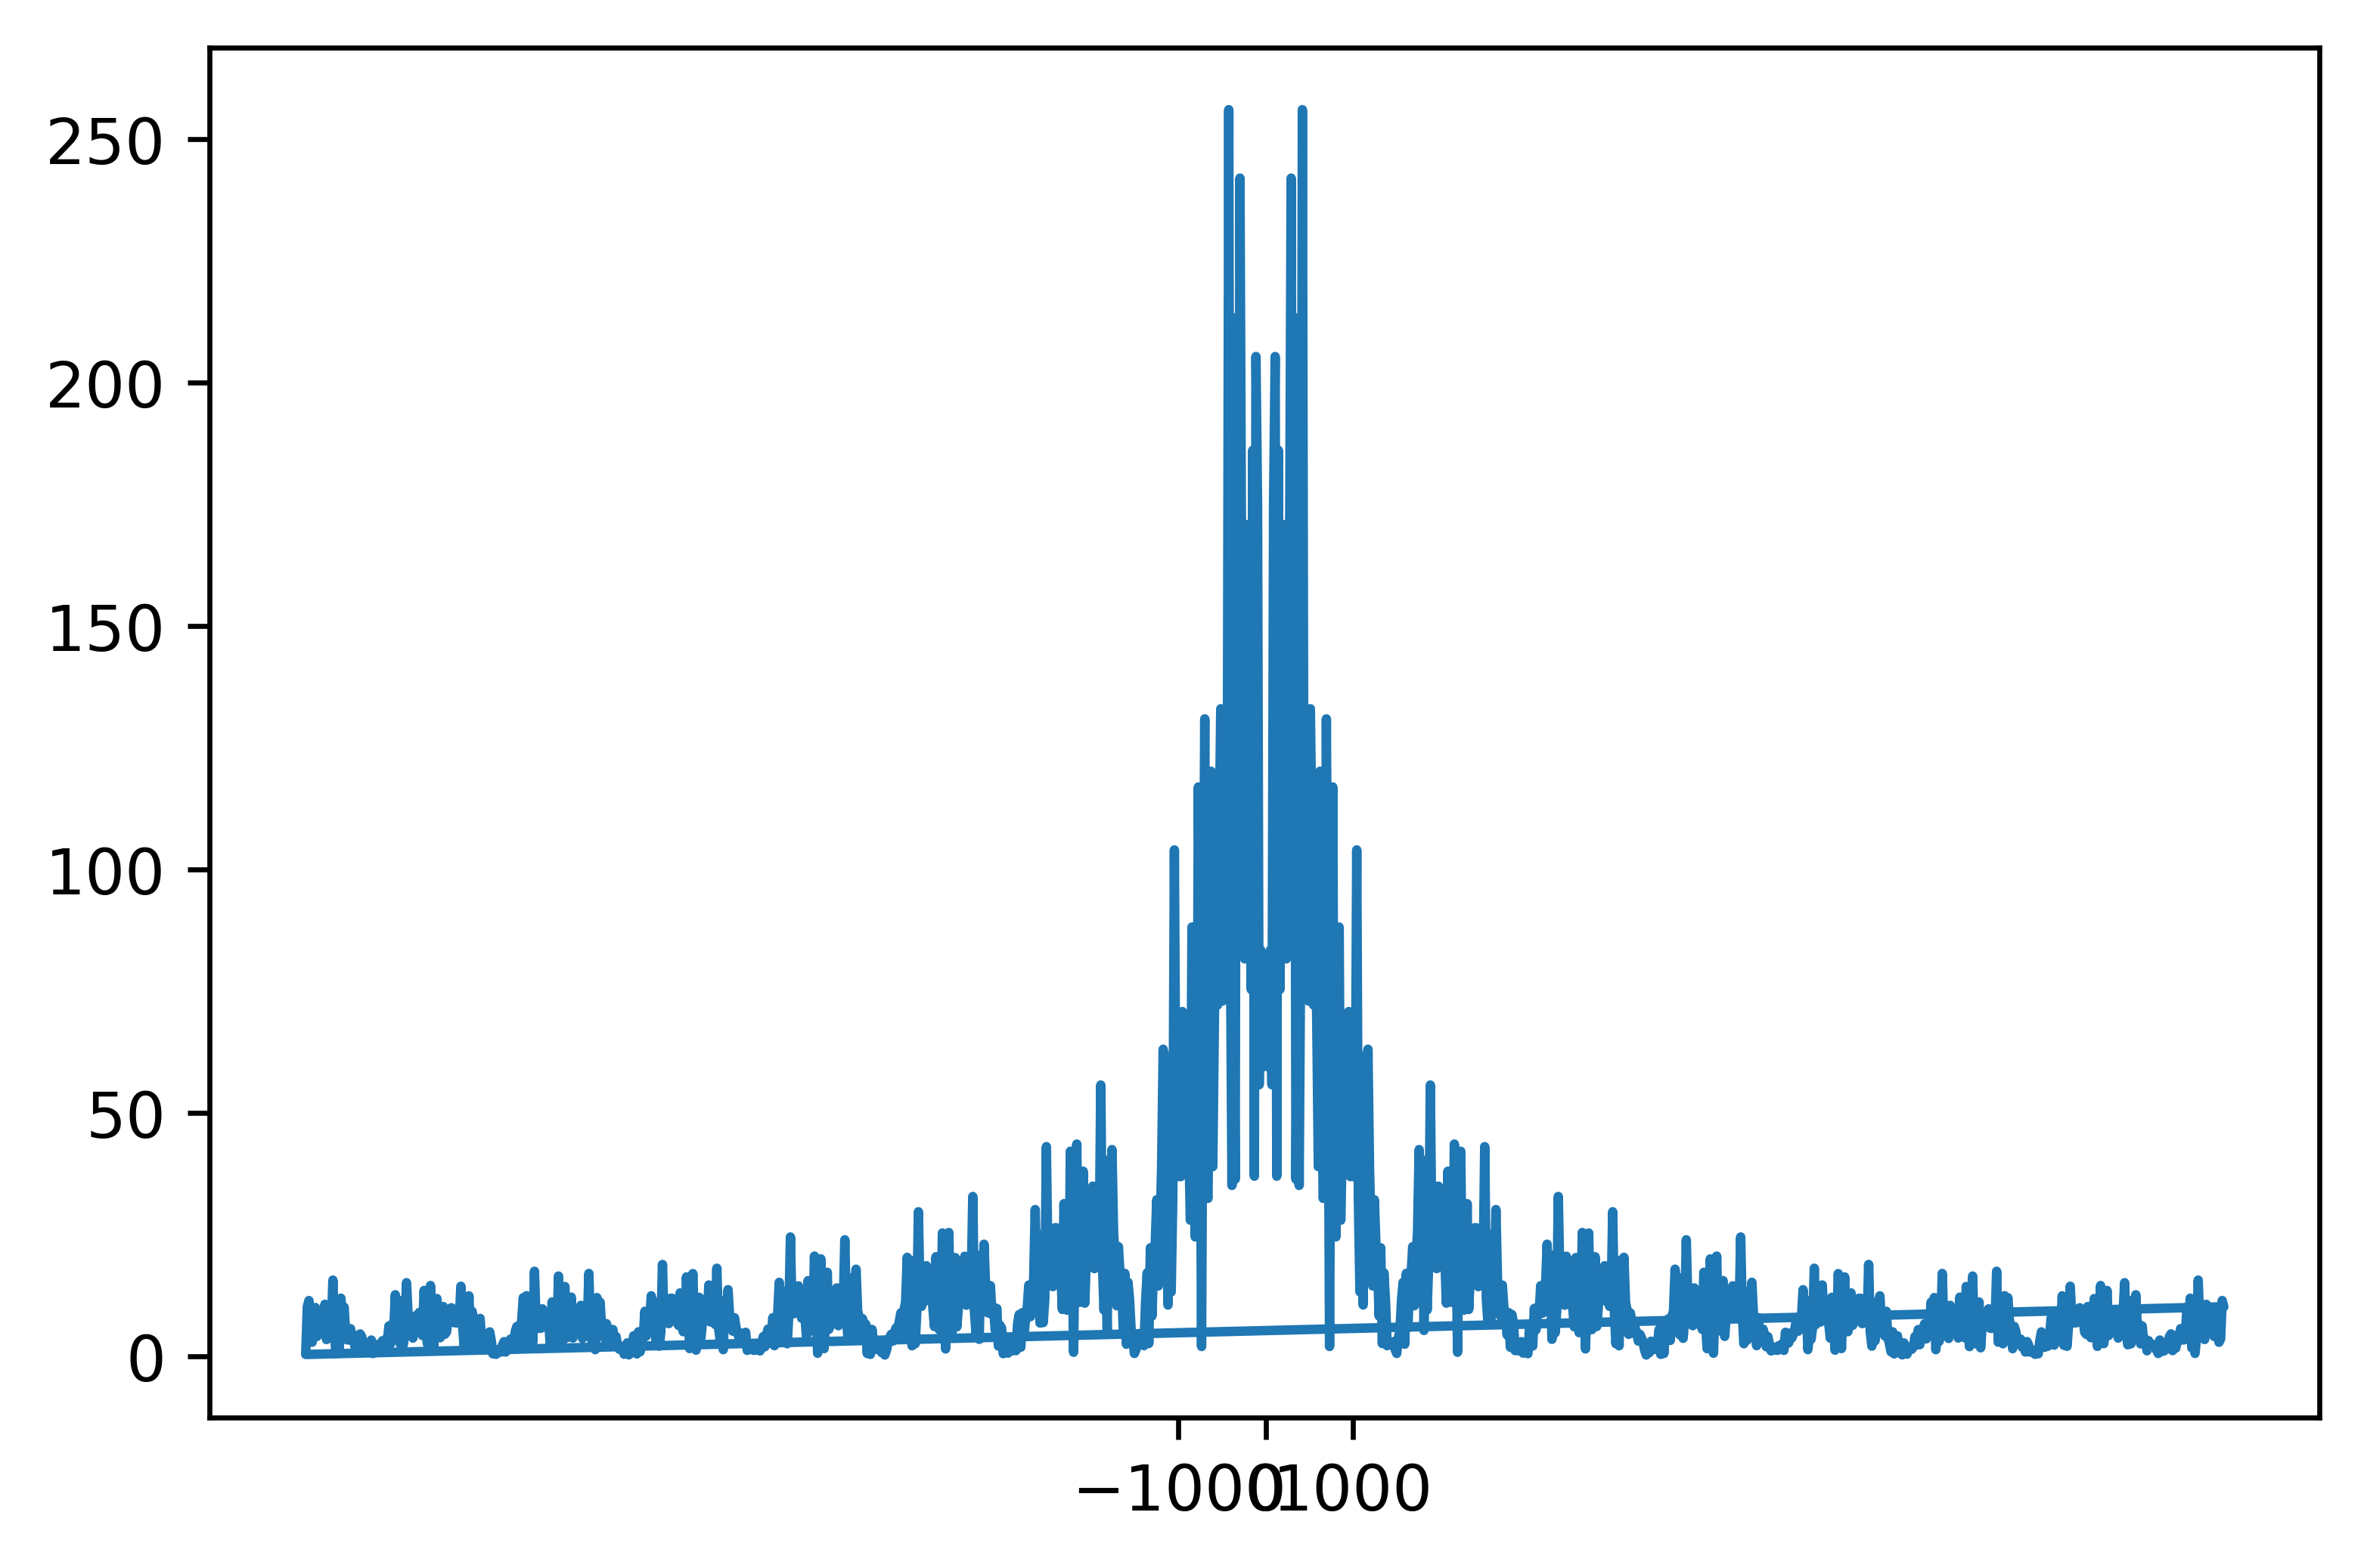

In [7]:
noisy_signal_frequencies = fft(noisy_signal)
plt.plot(f, abs(noisy_signal_frequencies))
plt.xticks(np.arange(-1000, 2000, 1000))
plt.show()

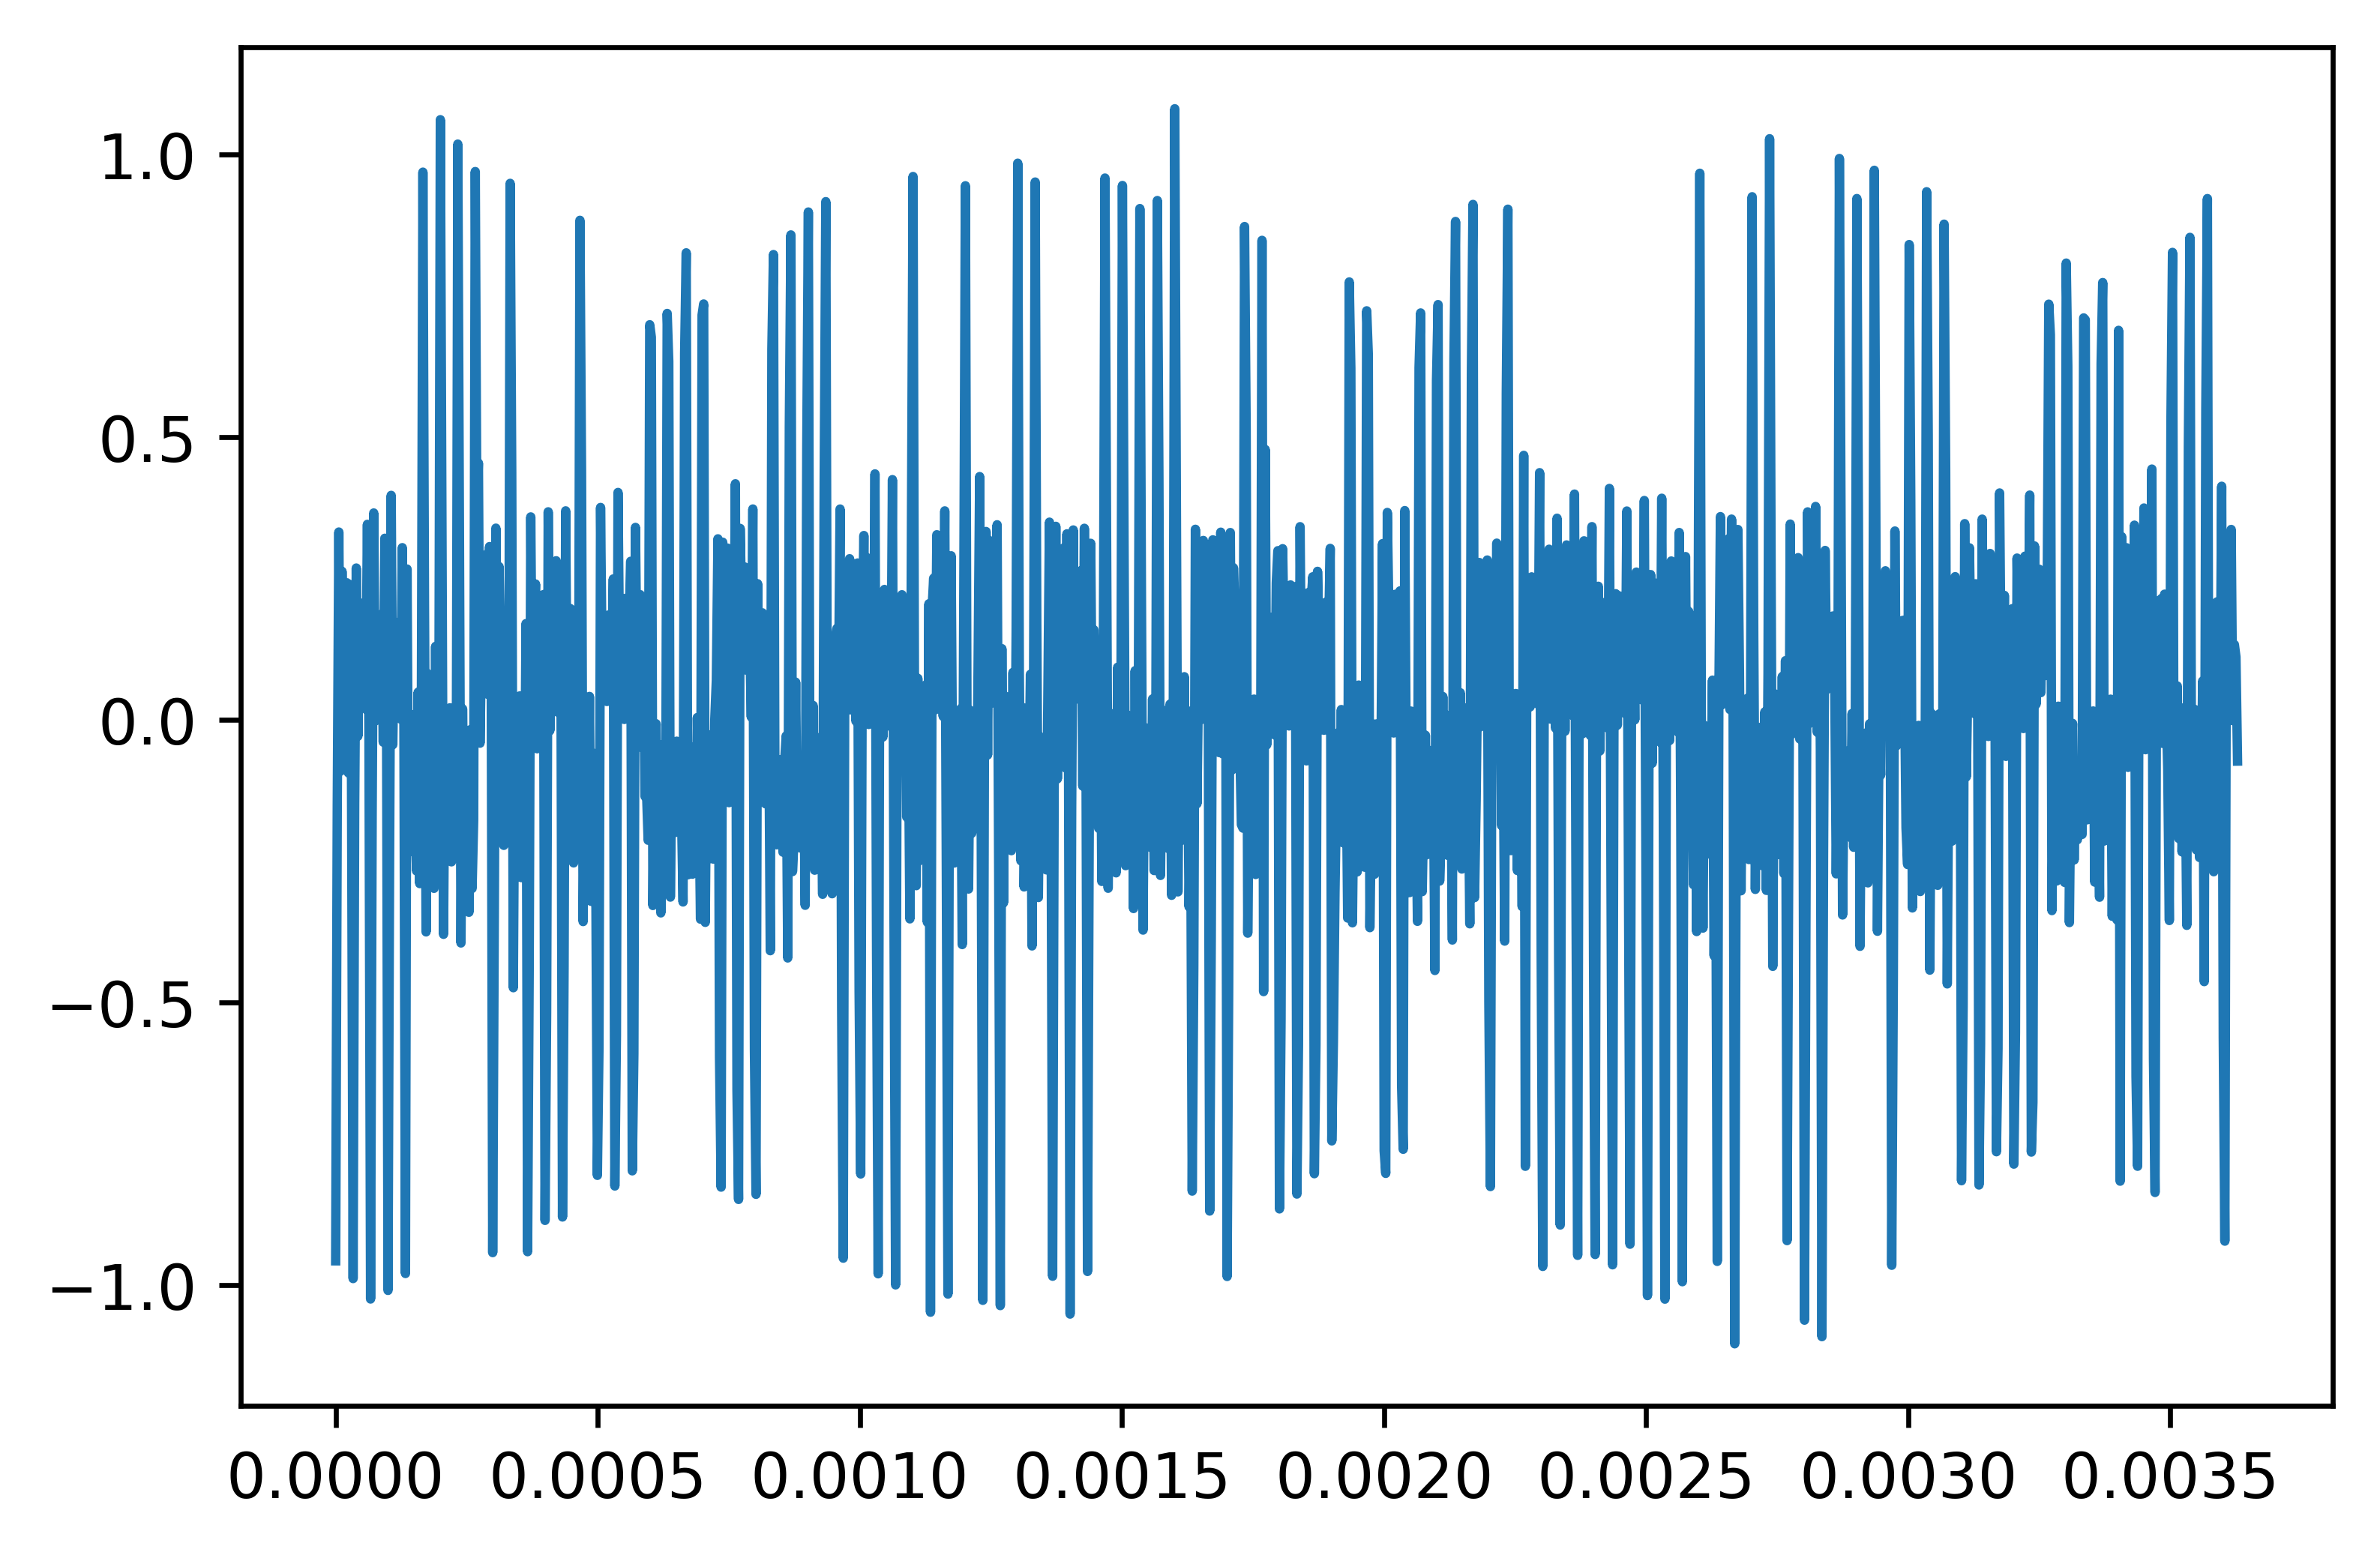

In [8]:
modulated_signal = modulation() * signal + white_noise
plt.plot(t, modulated_signal)
plt.show()

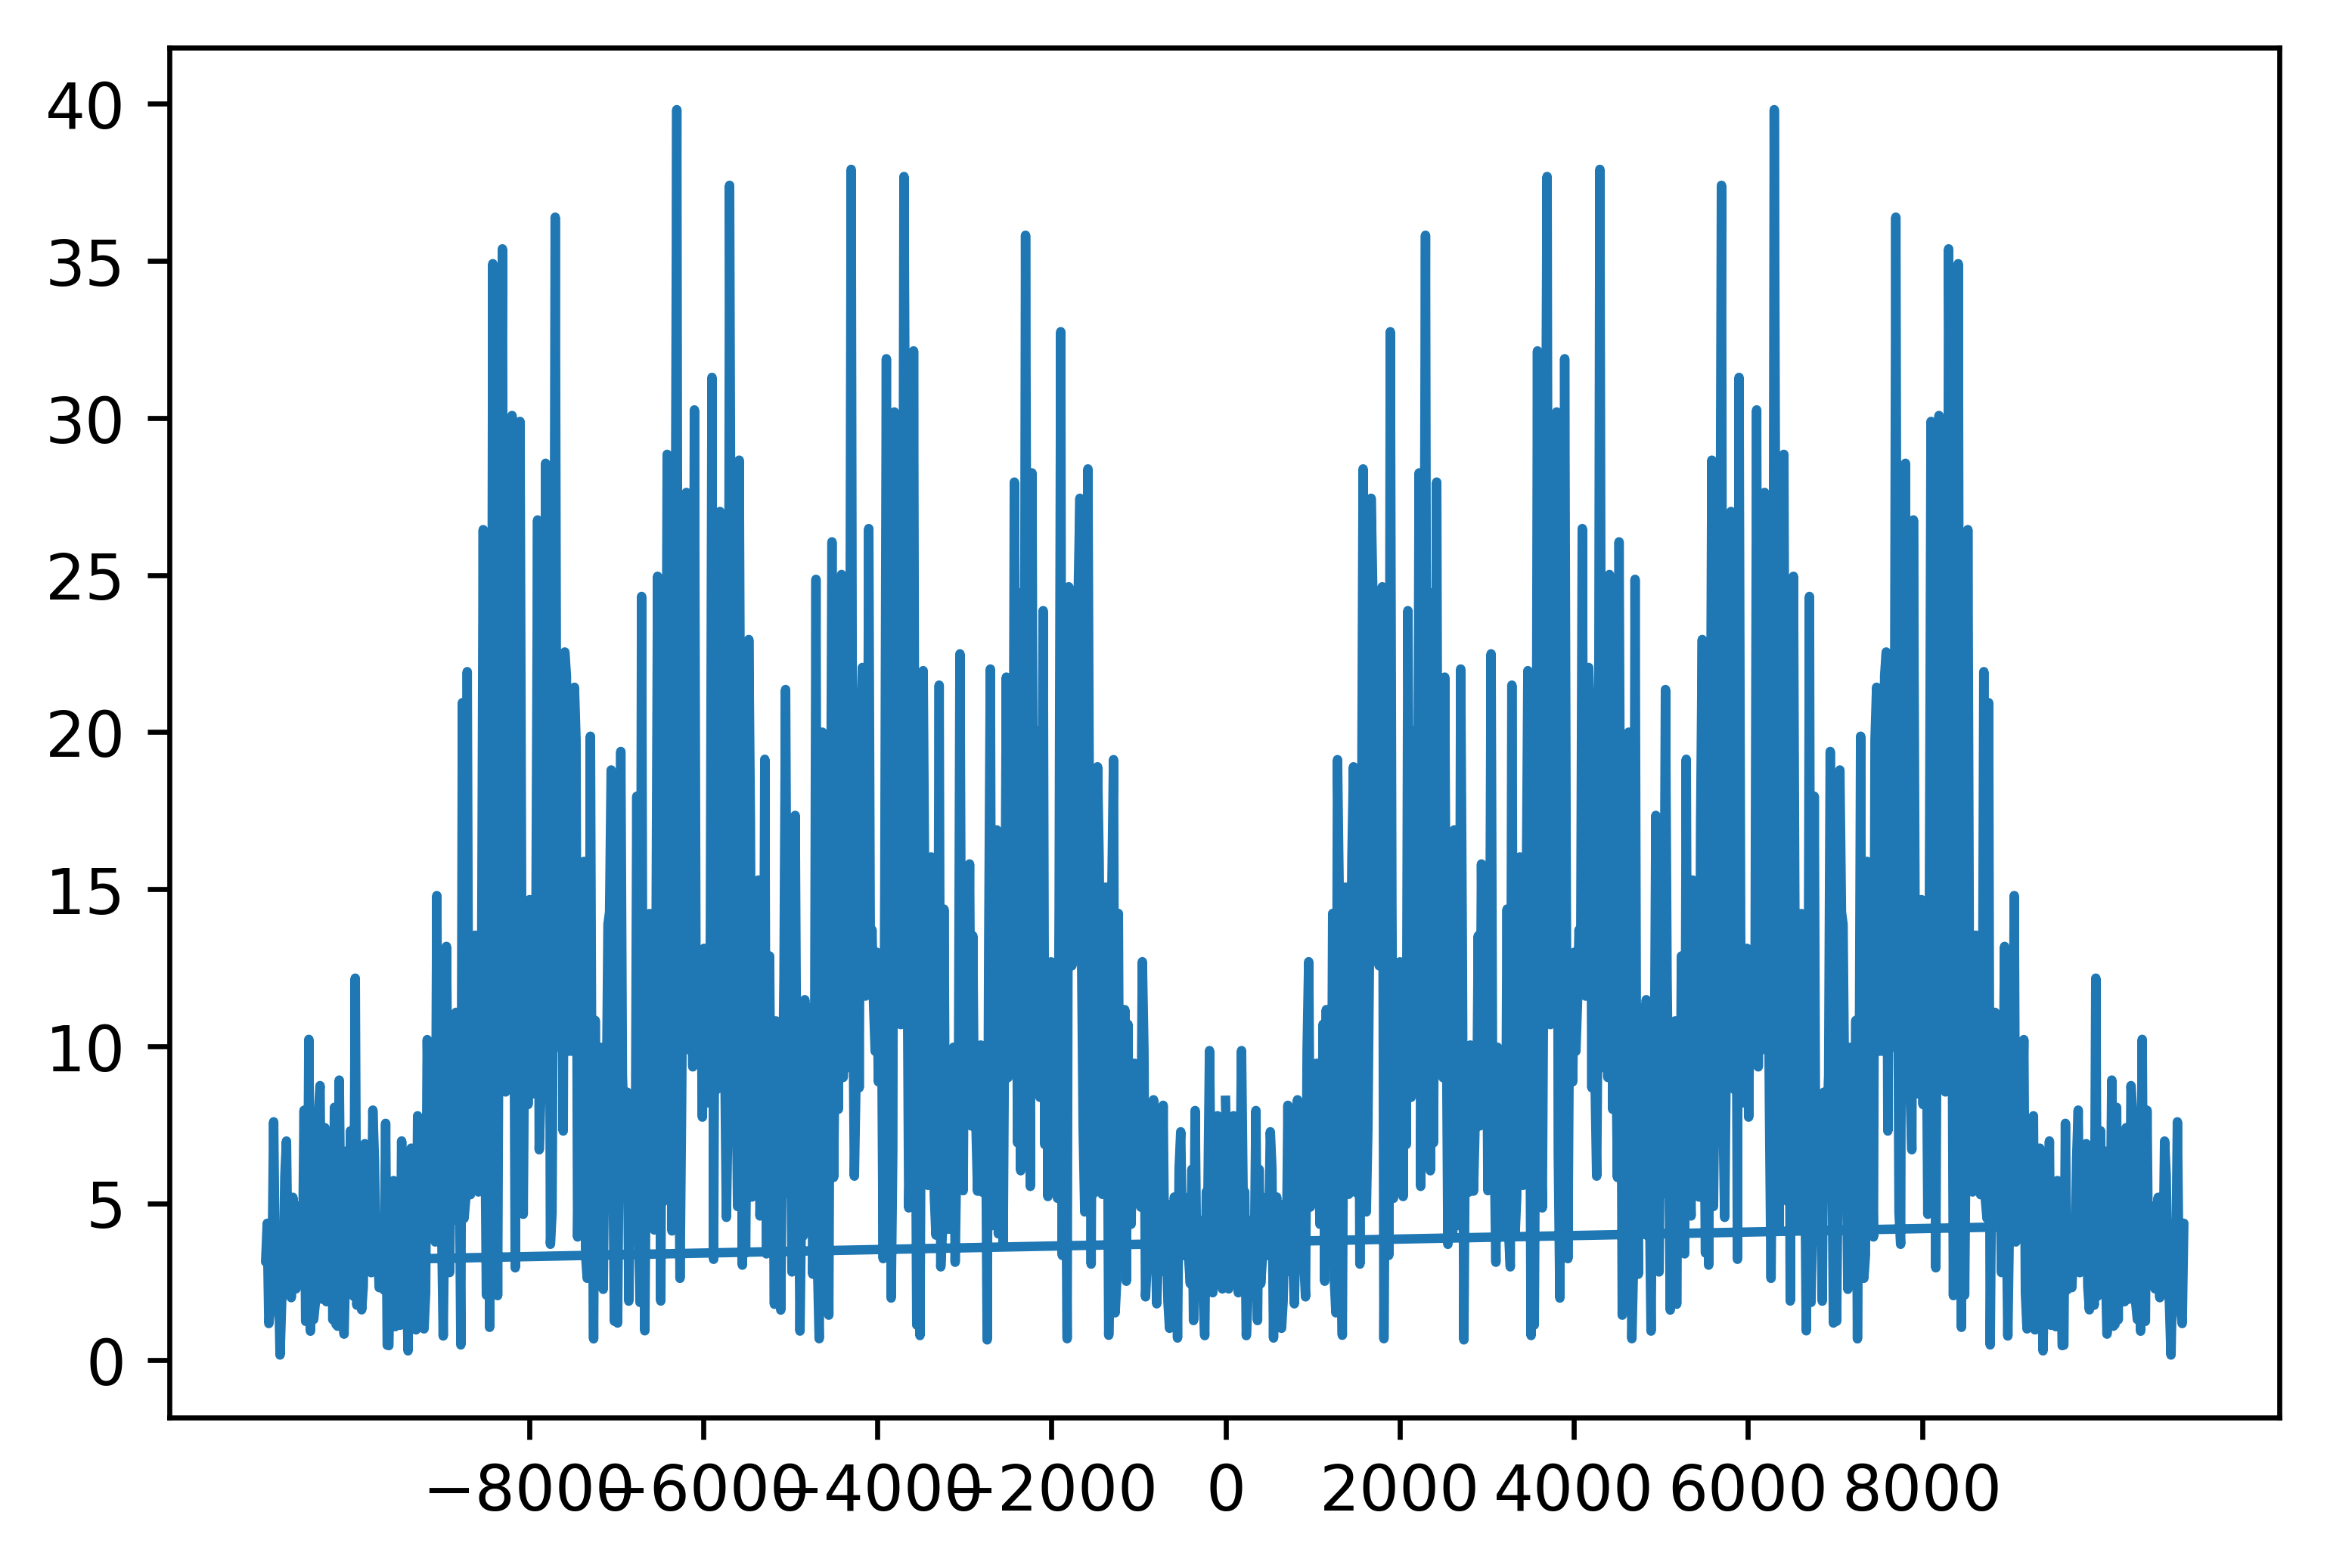

In [9]:
modulated_signal_frequencies = fft(modulated_signal)
plt.plot(f, abs(modulated_signal_frequencies))
plt.xticks(np.arange(-8000, 9000, 2000))
plt.show()

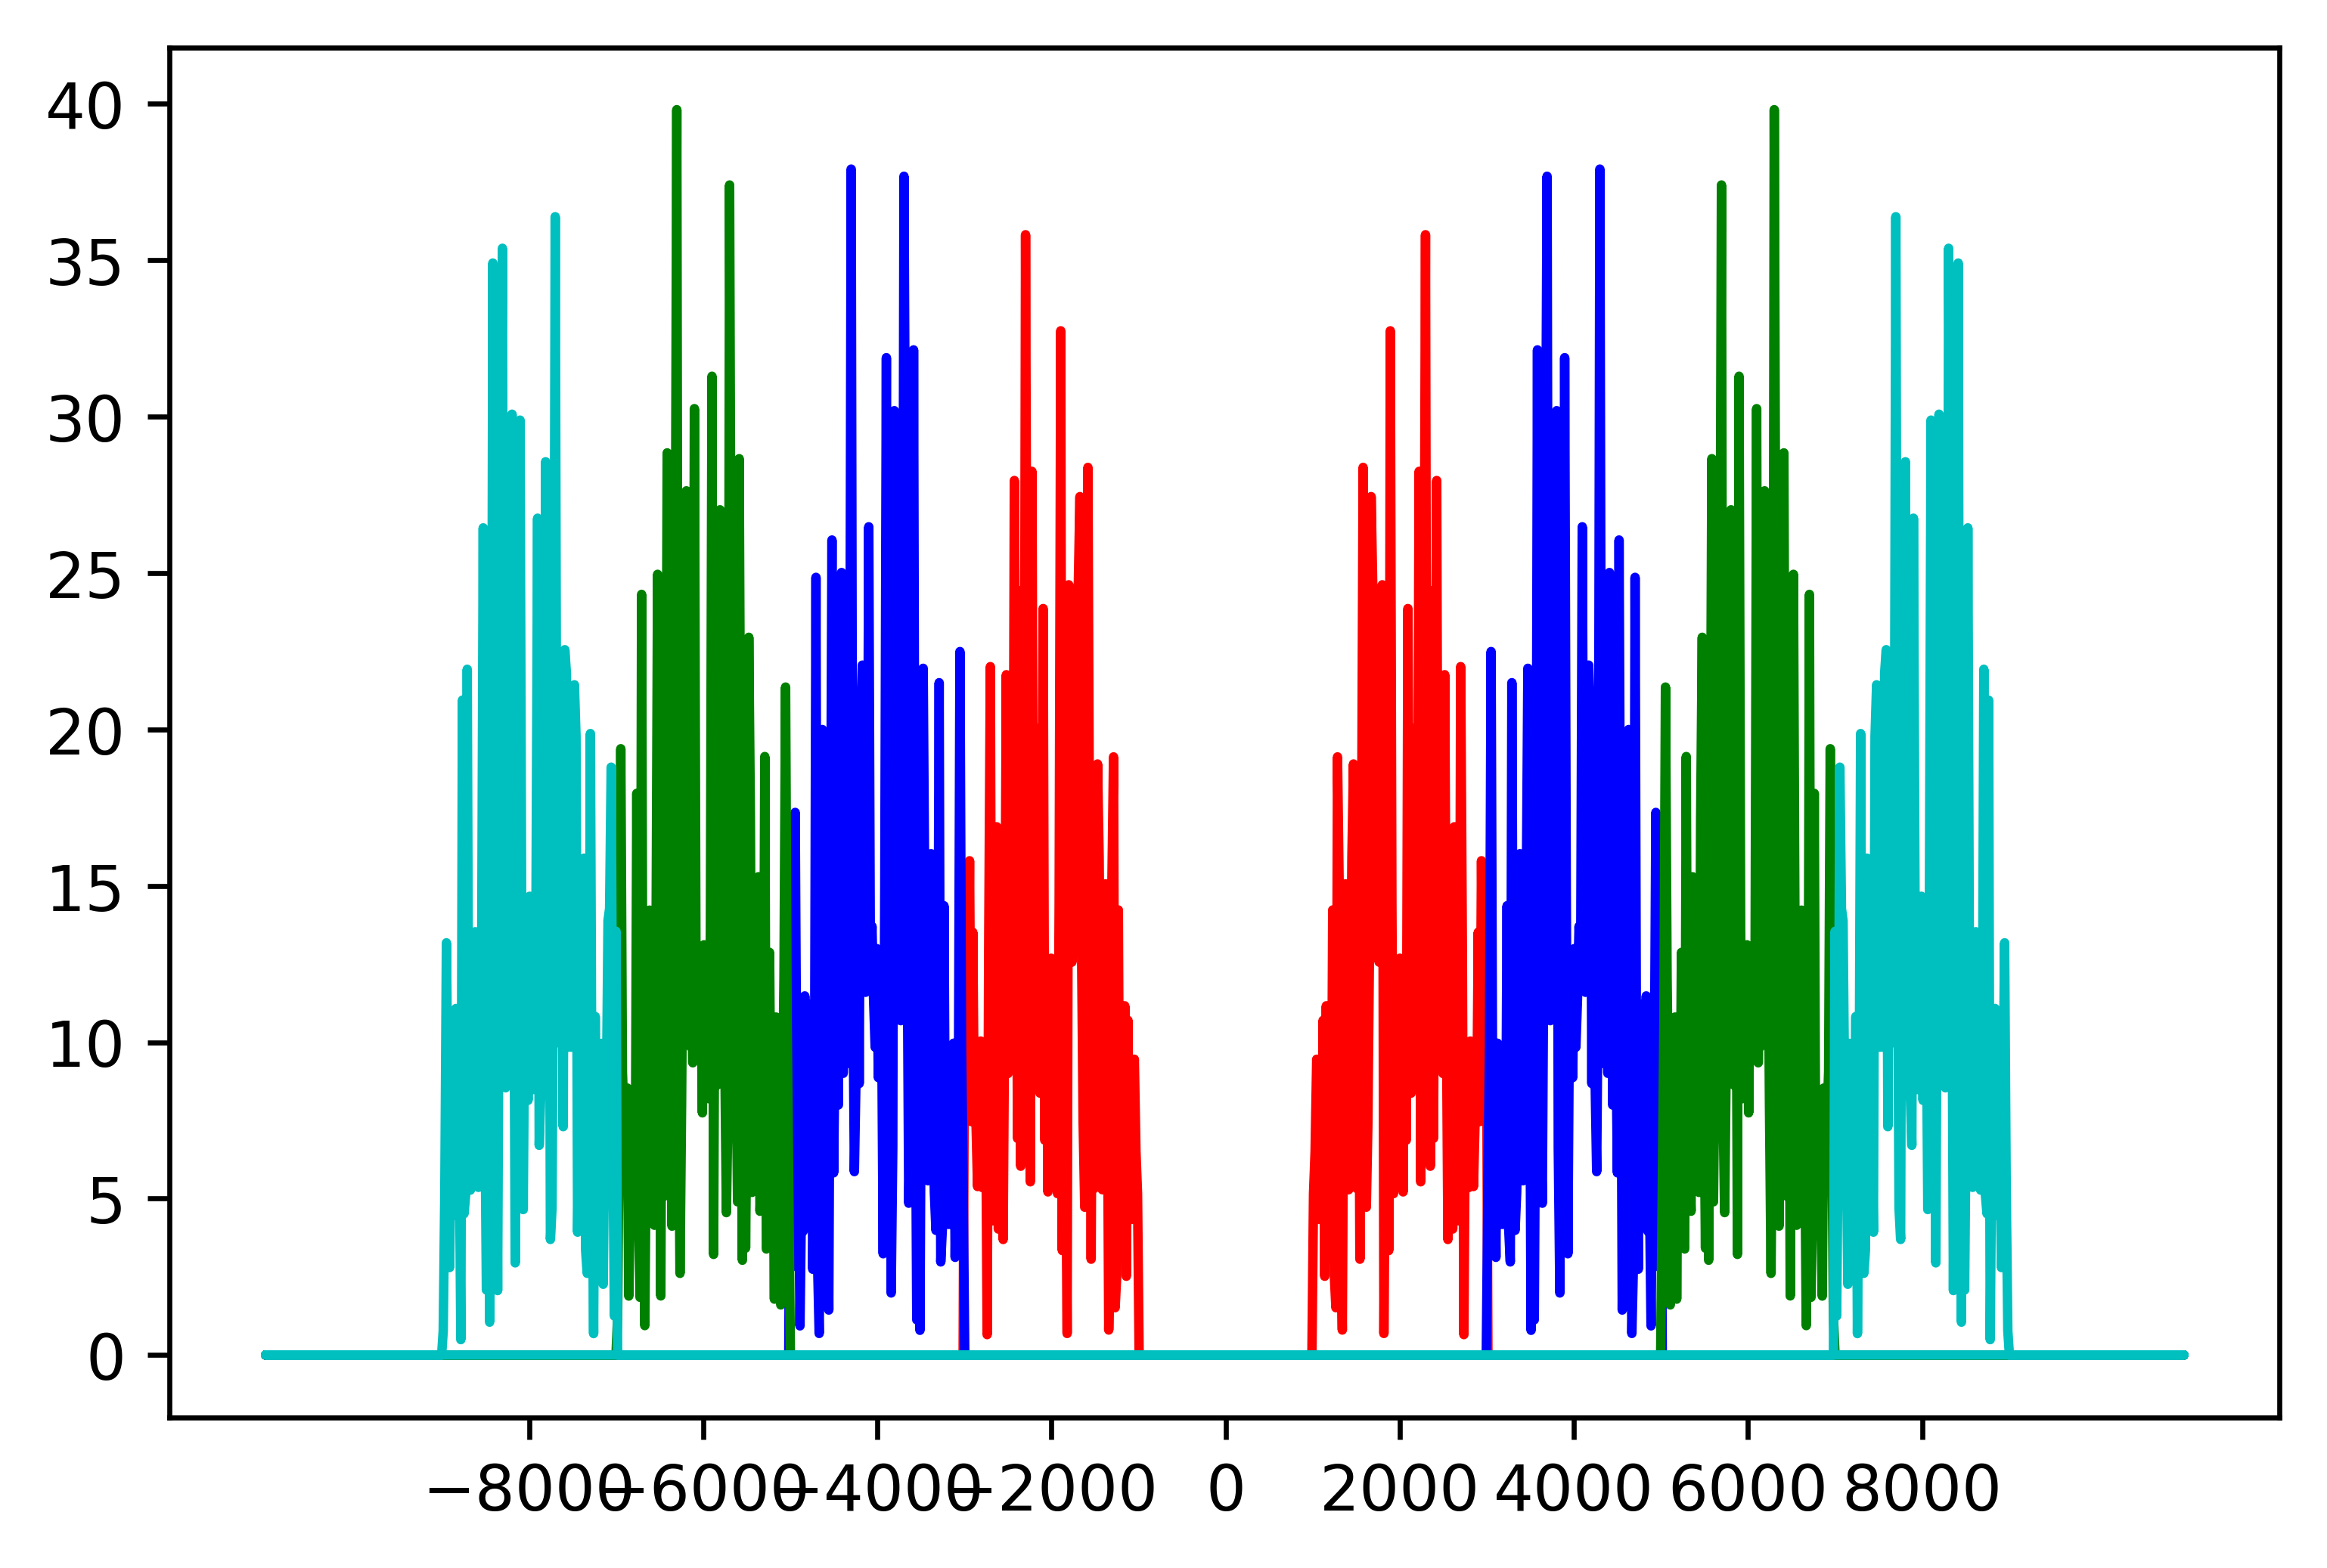

In [10]:
filtered_modulated_signal_frequencies_2000 = passband_filter(f, 2000, 2000) * modulated_signal_frequencies
filtered_modulated_signal_frequencies_4000 = passband_filter(f, 4000, 2000) * modulated_signal_frequencies
filtered_modulated_signal_frequencies_6000 = passband_filter(f, 6000, 2000) * modulated_signal_frequencies
filtered_modulated_signal_frequencies_8000 = passband_filter(f, 8000, 2000) * modulated_signal_frequencies

plt.plot(f, abs(filtered_modulated_signal_frequencies_2000), "r")
plt.plot(f, abs(filtered_modulated_signal_frequencies_4000), "b")
plt.plot(f, abs(filtered_modulated_signal_frequencies_6000), "g")
plt.plot(f, abs(filtered_modulated_signal_frequencies_8000), "c")
plt.xticks(np.arange(-8000, 9000, 2000))
plt.show()

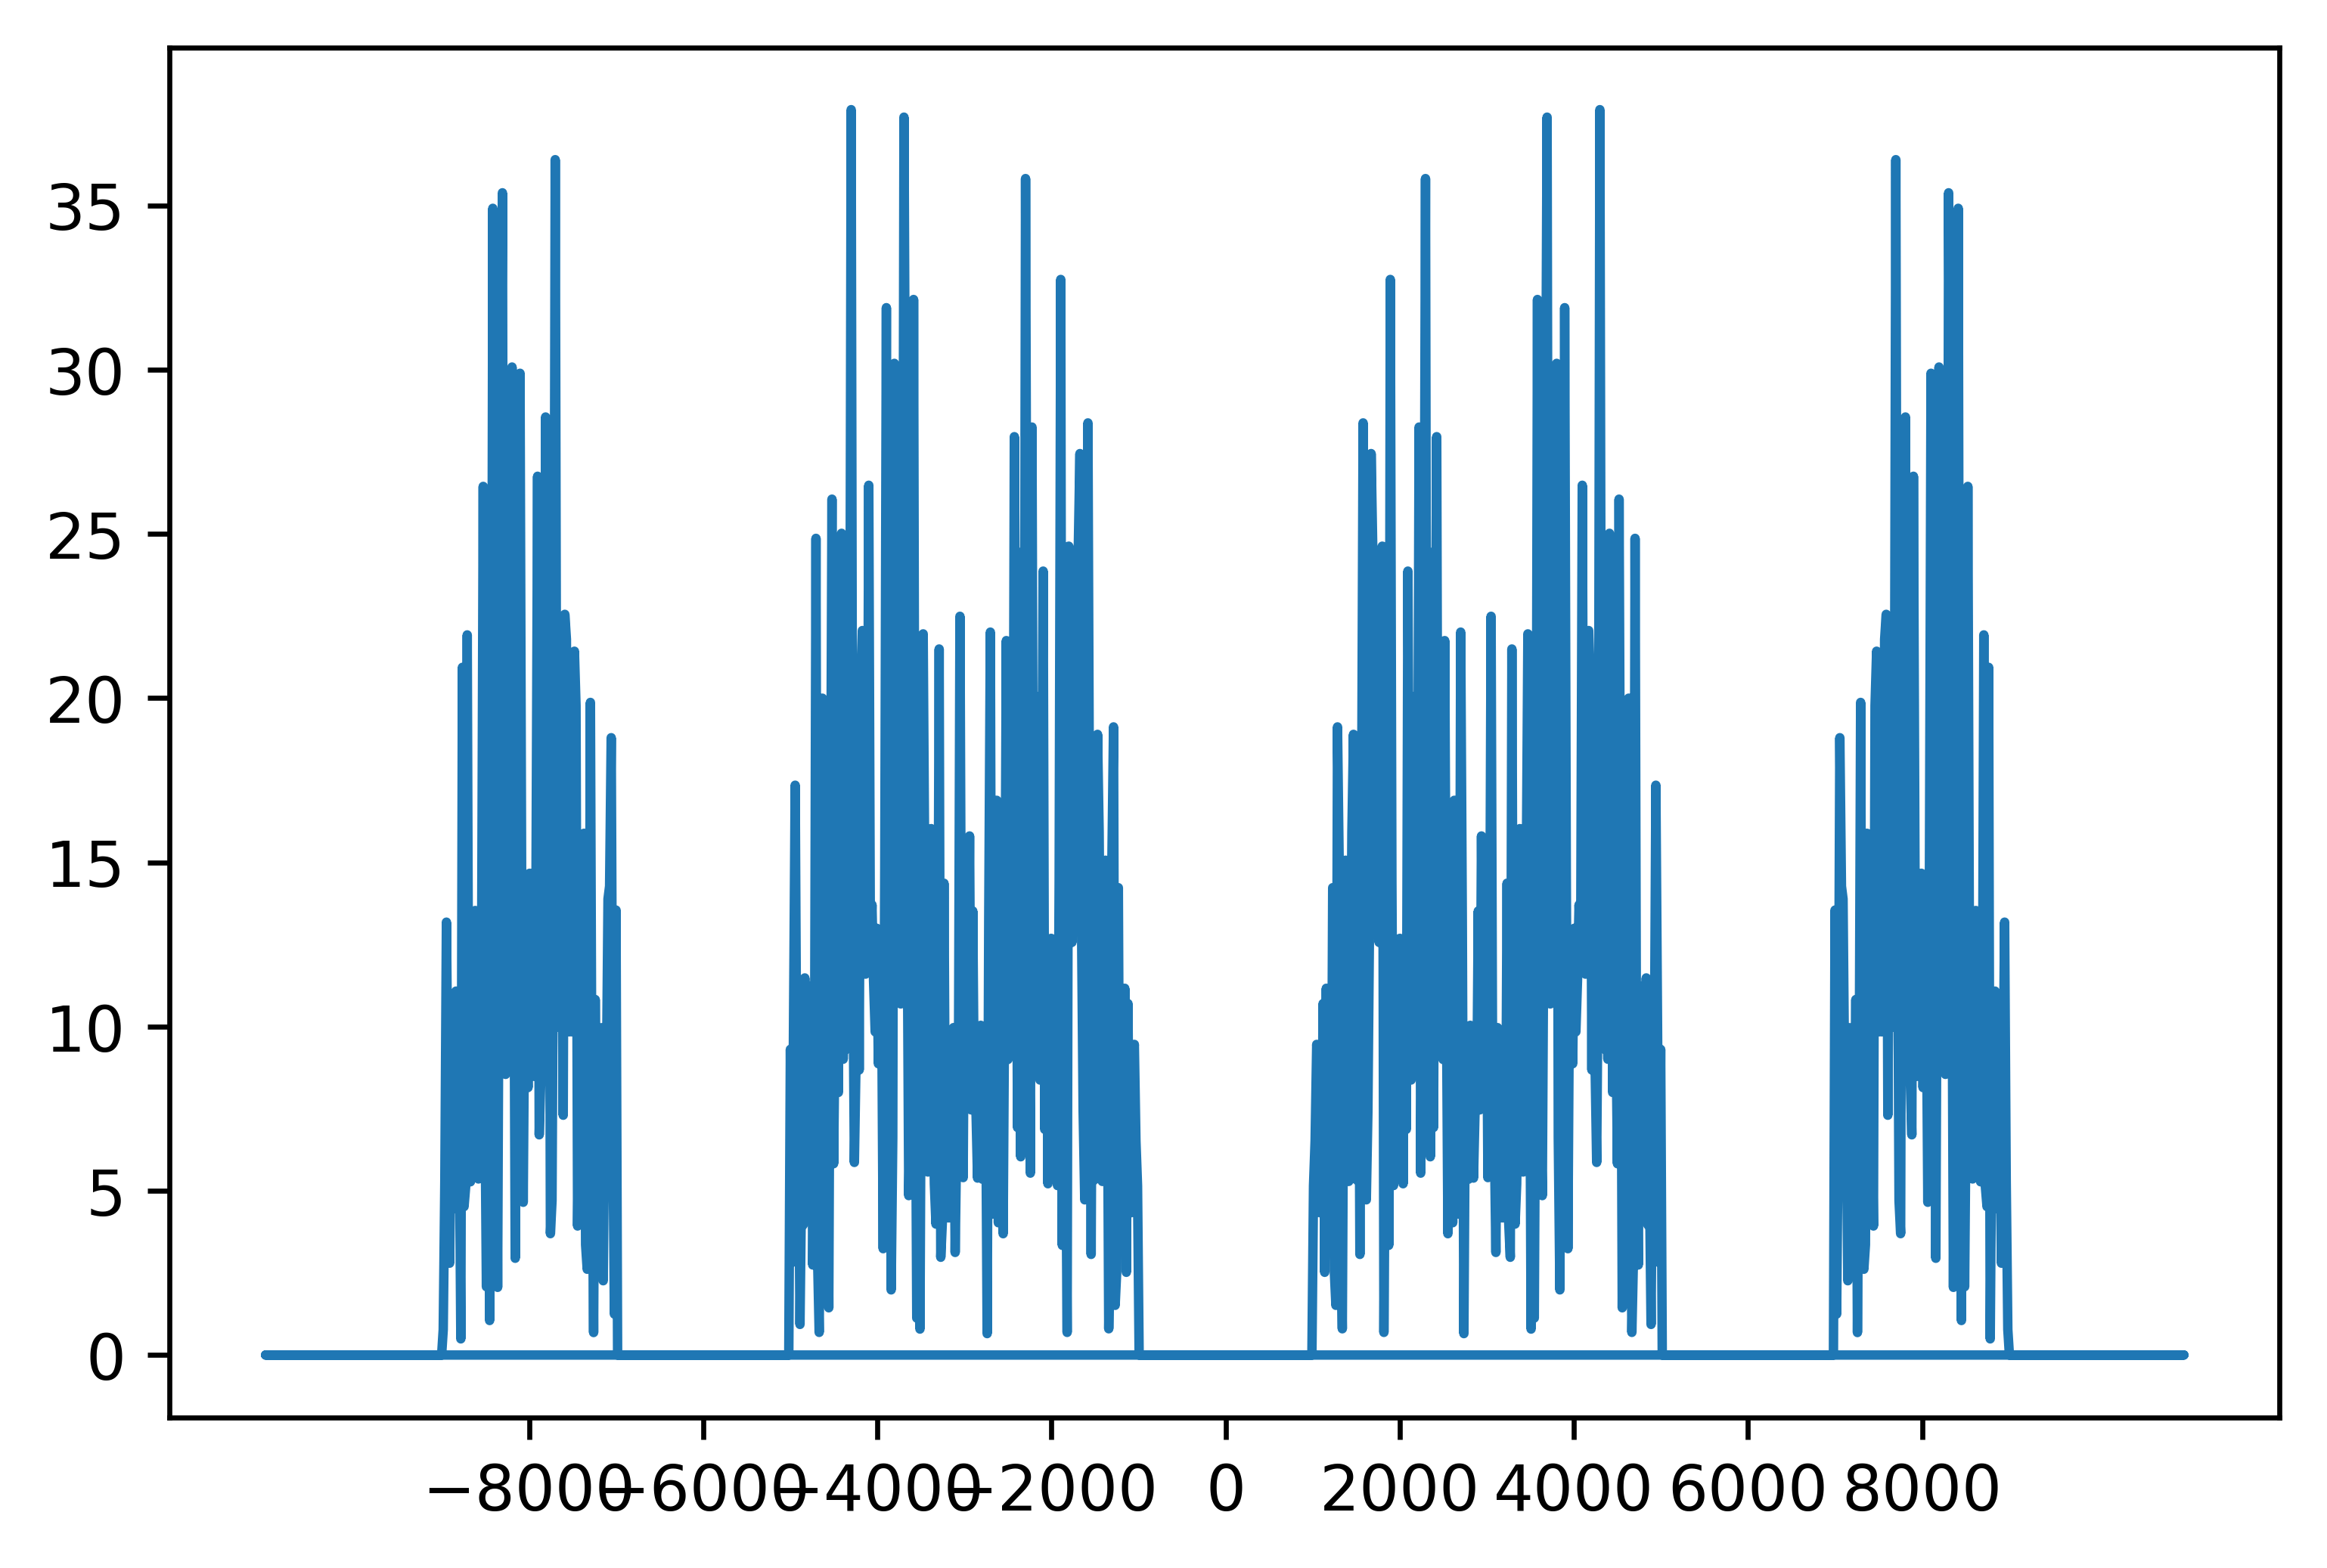

In [11]:
test = filtered_modulated_signal_frequencies_2000 + filtered_modulated_signal_frequencies_4000 + filtered_modulated_signal_frequencies_8000
plt.plot(f, abs(test))
plt.xticks(np.arange(-8000, 9000, 2000))
plt.show()